In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import folium  
import re
import shapely
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [3]:
nyc_squirrels=pd.read_csv('2018_Central_Park_Squirrel_Census_-_Squirrel_Data_20250304.csv')
hectare = pd.read_csv('2018_Central_Park_Squirrel_Census_-_Hectare_Grid_20250304.csv')
hectare_data = pd.read_csv('2018_Central_Park_Squirrel_Census_-_Hectare_Data_20250325.csv')

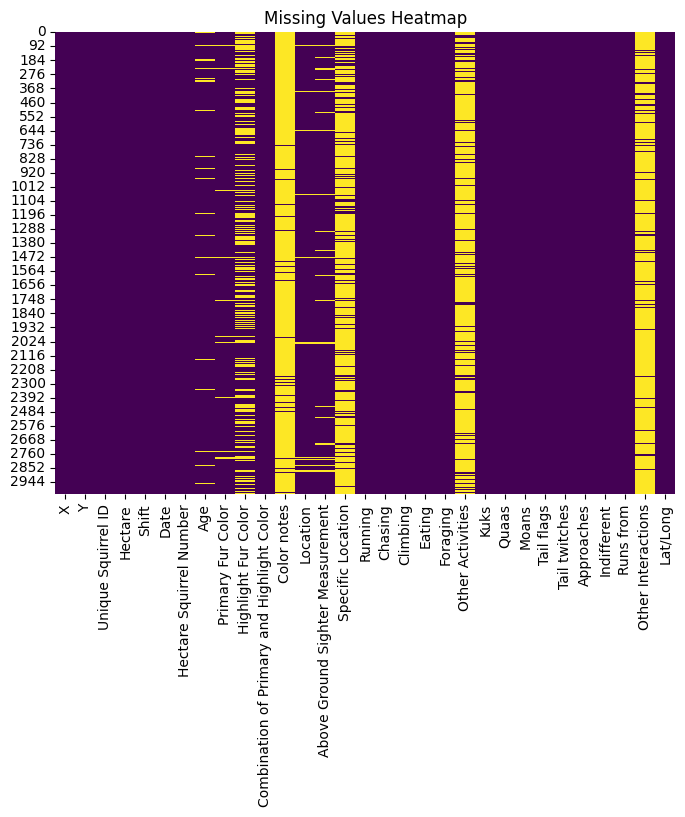

In [6]:
#squirrel missingness
plt.figure(figsize=(8,6))
sns.heatmap(nyc_squirrels.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
#plt.savefig('Missing Squirrel Data', dpi=300)
plt.show()

In [12]:
#seperating the latitude and longitude 

# Extract coordinate pairs using regex
def extract_coords(wkt):
    # Remove the leading "MULTIPOLYGON (((" and trailing ")))"
    cleaned = re.sub(r'^MULTIPOLYGON\s+\(\(\(|\)\)\)$', '', wkt)
    # Split into individual coordinate pairs
    coord_pairs = cleaned.split(', ')
    # Split each pair into lon and lat
    coords = [coord.split() for coord in coord_pairs]
    return coords

# Apply extraction
hectare['coords'] = hectare['the_geom'].apply(extract_coords)

# Convert coordinate lists to individual columns
# Flatten coordinates into new DataFrame columns
coord_df = hectare['coords'].apply(lambda x: pd.Series([float(num) for pair in x for num in pair]))

# Rename the columns as lon_1, lat_1, lon_2, lat_2, ...
coord_df.columns = [f"{'lon' if i % 2 == 0 else 'lat'}_{i//2 + 1}" for i in coord_df.columns]

# Concatenate with original DataFrame
hectare_final = pd.concat([hectare.drop(columns='coords'), coord_df], axis=1)

print(hectare_final)


                                              the_geom   id          xmin  \
0    MULTIPOLYGON (((-73.95816284567162 40.80102139...   82  989030.73113   
1    MULTIPOLYGON (((-73.95712568765475 40.80058581...   83  989358.81512   
2    MULTIPOLYGON (((-73.95608854321127 40.80015023...   84  989686.89911   
3    MULTIPOLYGON (((-73.9550514123412 40.799714636...   85  990014.98310   
4    MULTIPOLYGON (((-73.9540142950446 40.799279030...   86  990343.06709   
..                                                 ...  ...           ...   
373  MULTIPOLYGON (((-73.97750517097374 40.76696330...  865  990343.06709   
374  MULTIPOLYGON (((-73.97646841686014 40.76652789...  866  990671.15108   
375  MULTIPOLYGON (((-73.97543167630229 40.76609247...  867  990999.23507   
376  MULTIPOLYGON (((-73.97439494930025 40.76565705...  868  991327.31906   
377  MULTIPOLYGON (((-73.97335823585396 40.76522162...  869  991655.40305   

             xmax          ymin          ymax      lon_1      lat_1  \
0   

In [15]:
#saving the location of one squirrel identified in each hectare
squirrel_hec_id = nyc_squirrels[['X','Y','Hectare']]
squirrel_hec_id = squirrel_hec_id.sort_values(by = 'Hectare')
squirrel_hec_id.drop_duplicates(subset=["Hectare"], keep="first", inplace=True)
squirrel_hec_id.reset_index(drop=True, inplace=True)

#making and naming the polygons with shapely
hectares_shapely = []
for i in range(len(hectare_final)):
    p = (Polygon([(hectare_final.iloc[i,7],hectare_final.iloc[i,6]),
                  (hectare_final.iloc[i,9],hectare_final.iloc[i,8]),
                  (hectare_final.iloc[i,11],hectare_final.iloc[i,10]),
                  (hectare_final.iloc[i,13],hectare_final.iloc[i,12])]),
                 f'{hectare_final.iloc[i,1]}')
    hectares_shapely.append(p)

#finding which hectare each squirrel point belongs in
hectare_assign = []
for i in range(len(squirrel_hec_id)):
    p = Point(squirrel_hec_id.iloc[i,1],squirrel_hec_id.iloc[i,0])
    for s in hectares_shapely:
        if s[0].contains(p) == True:
            h = (([squirrel_hec_id.iloc[i,2],s[1]]))
            hectare_assign.append(h)
     
hectare_assign = pd.DataFrame(hectare_assign, columns = ['Hectare', 'id'])
hectare_assign['id'] = hectare_assign['id'].astype('int64')

#joinging the squirrels data with the hectare id number
nyc_squirrels = nyc_squirrels.merge(hectare_assign, how='left', on='Hectare')

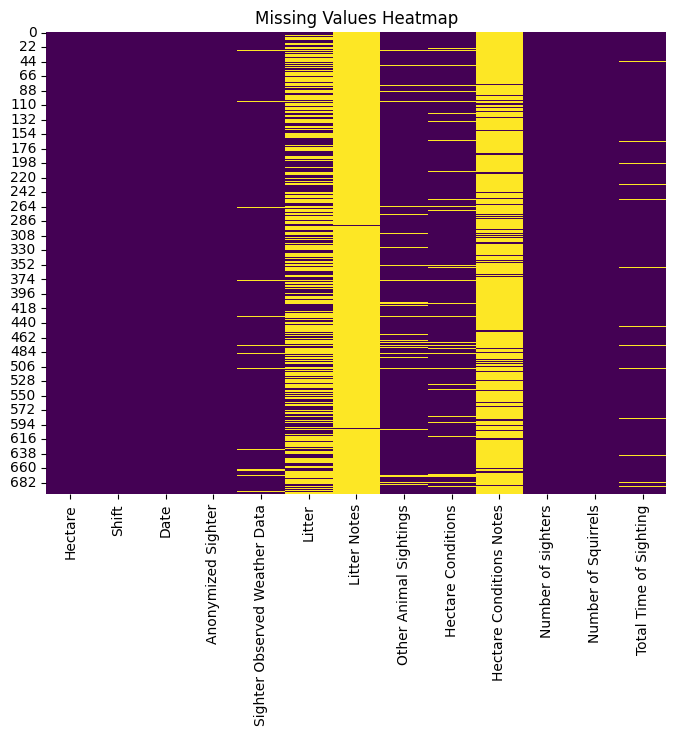

In [4]:
#hectare missingness
plt.figure(figsize=(8,6))
sns.heatmap(hectare_data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
#plt.savefig('Missing Squirrel Data', dpi=300)
plt.show()

In [5]:
#clean data

#check amount of missing data in each column 
missing_data = nyc_squirrels.isna().sum()
print(missing_data)

print("Total squirrels in dataset: ", len(nyc_squirrels))

#drop unneded columns 
drop_columns_ap = ['Color notes', 'Specific Location', 'Other Activities', 'Other Interactions', 'Highlight Fur Color']
clean_squirrels_ap = nyc_squirrels.drop(columns = drop_columns_ap)
clean_squirrels_ap = clean_squirrels_ap.dropna()
missing_data_ap = clean_squirrels_ap.isna().sum()
print(missing_data_ap)
clean_squirrels_ap


X                                                0
Y                                                0
Unique Squirrel ID                               0
Hectare                                          0
Shift                                            0
Date                                             0
Hectare Squirrel Number                          0
Age                                            121
Primary Fur Color                               55
Highlight Fur Color                           1086
Combination of Primary and Highlight Color       0
Color notes                                   2841
Location                                        64
Above Ground Sighter Measurement               114
Specific Location                             2547
Running                                          0
Chasing                                          0
Climbing                                         0
Eating                                           0
Foraging                       

,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Combination of Primary and Highlight Color,...,Foraging,Kuks,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from,Lat/Long
6,-73.954120,40.793181,36H-AM-1010-02,36H,AM,10102018,2,Adult,Gray,Gray+,...,True,False,False,False,False,False,False,False,False,POINT (-73.9541201789795 40.7931811701082)
7,-73.958269,40.791737,33F-AM-1008-02,33F,AM,10082018,2,Adult,Gray,Gray+,...,True,False,False,False,False,False,False,True,False,POINT (-73.9582694312289 40.7917367820255)
8,-73.967429,40.782972,21C-PM-1006-01,21C,PM,10062018,1,Adult,Gray,Gray+,...,False,False,False,False,True,True,False,False,False,POINT (-73.9674285955293 40.7829723919744)
9,-73.972250,40.774288,11D-AM-1010-03,11D,AM,10102018,3,Adult,Gray,Gray+Cinnamon,...,False,False,False,False,False,False,False,True,False,POINT (-73.9722500196844 40.7742879599026)
10,-73.969506,40.782351,20B-PM-1013-05,20B,PM,10132018,5,Adult,Gray,Gray+White,...,True,False,False,False,False,False,False,True,False,POINT (-73.9695063535333 40.7823507678183)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3017,-73.964544,40.781160,21F-PM-1018-02,21F,PM,10182018,2,Juvenile,Cinnamon,Cinnamon+Gray,...,True,False,False,False,False,False,False,False,True,POINT (-73.9645437409662 40.7811599933331)
3018,-73.963943,40.790868,30B-AM-1007-04,30B,AM,10072018,4,Adult,Gray,Gray+,...,True,False,False,False,False,False,False,False,True,POINT (-73.9639431360458 40.7908677445466)
3019,-73.970402,40.782560,19A-PM-1013-05,19A,PM,10132018,5,Adult,Gray,Gray+White,...,True,False,False,False,False,False,False,True,False,POINT (-73.9704015859639 40.7825600069973)
3020,-73.966587,40.783678,22D-PM-1012-07,22D,PM,10122018,7,Adult,Gray,"Gray+Black, Cinnamon, White",...,True,False,False,False,False,False,False,True,False,POINT (-73.9665871993517 40.7836775064883)


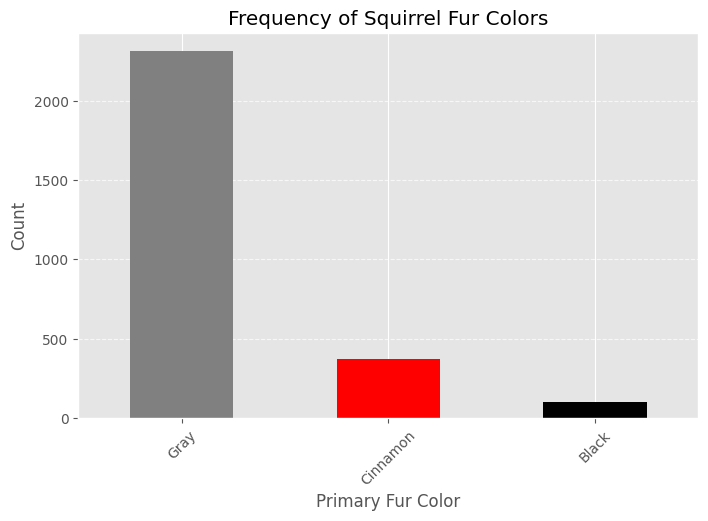

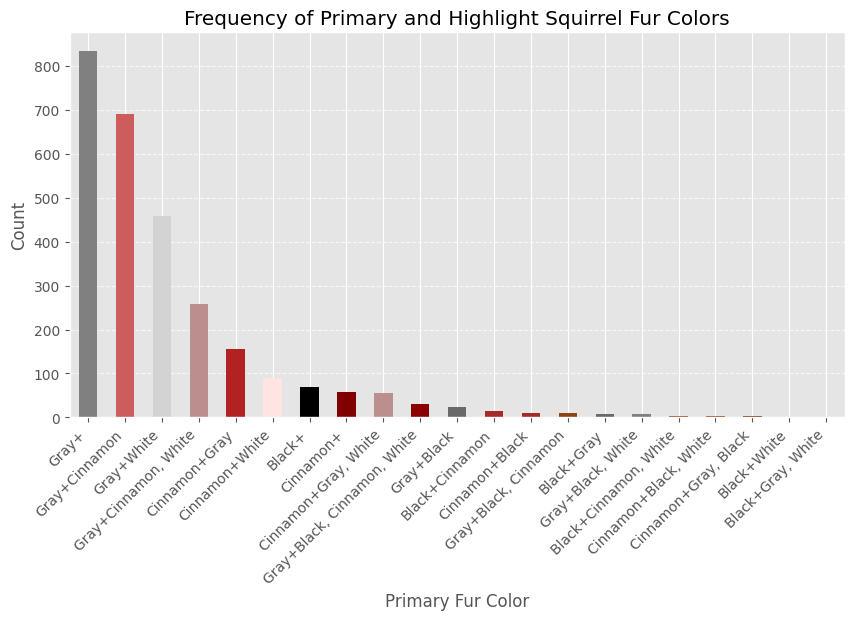

In [12]:
#Primary fur color
fur_color_ap = clean_squirrels_ap['Primary Fur Color'].value_counts()

plt.figure(figsize=(8, 5))
fur_color_ap.plot(kind="bar", color=["Gray", "Red", "Black"])

plt.title("Frequency of Squirrel Fur Colors")
plt.xlabel("Primary Fur Color")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

#Combination of primary and highlight
prim_high_color_ap = clean_squirrels_ap['Combination of Primary and Highlight Color'].value_counts()

plt.figure(figsize=(10, 5))
prim_high_color_ap.plot(kind="bar", color=["Gray", "indianred", "lightgray", "rosybrown", "firebrick", "mistyrose", "Black", "Maroon", "rosybrown", "darkred", "dimgray",
                                          "brown", "brown", "saddlebrown", "dimgray", "gray", "sienna", "sienna", "saddlebrown", "gainsboro", "gray"])

plt.title("Frequency of Primary and Highlight Squirrel Fur Colors")
plt.xlabel("Primary Fur Color")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

       Quaas  Moans  Tail flags  Runs from
False   2740   2783        2637       2154
True      44      1         147        630


<Figure size 800x500 with 0 Axes>

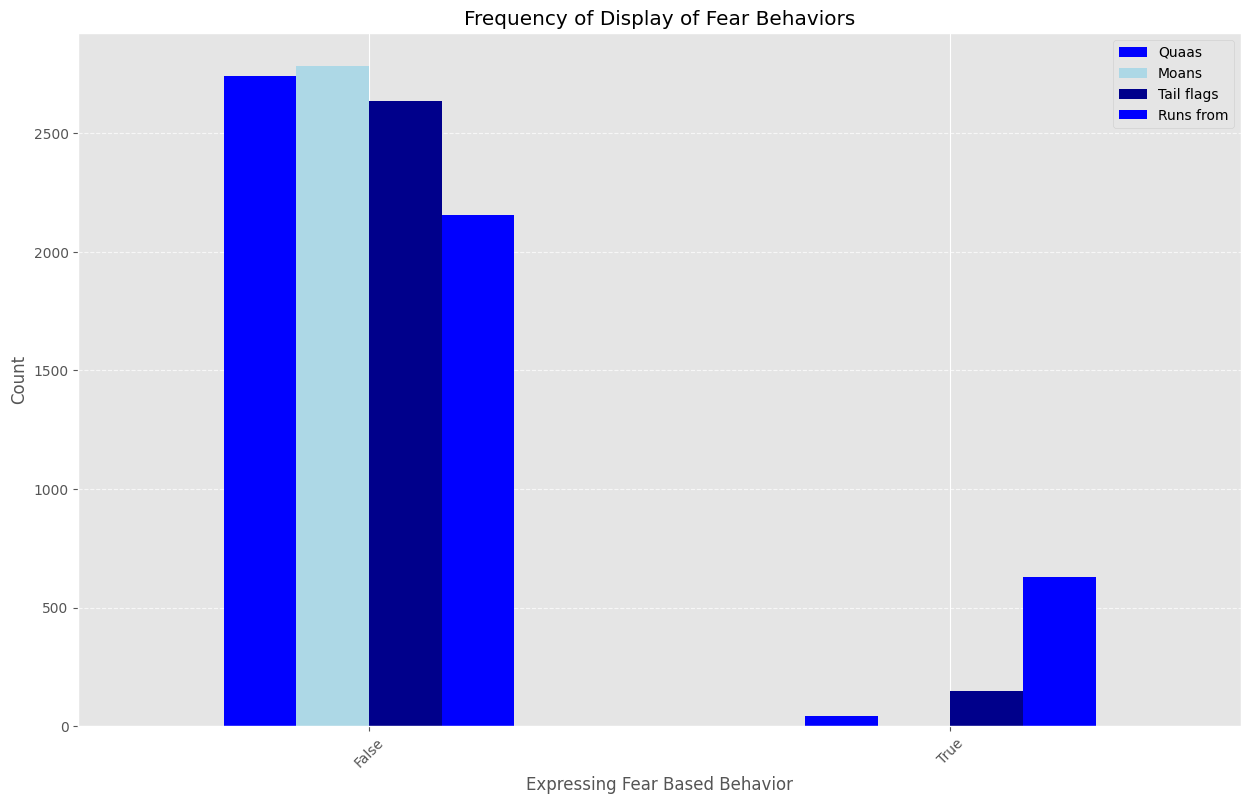

In [13]:
#Dispays of fear

fear_columns_ap = ['Quaas', 'Moans', 'Tail flags', 'Runs from']
fear_ap = clean_squirrels_ap[fear_columns_ap].apply(pd.Series.value_counts)
print(fear_ap)

plt.figure(figsize=(8, 5))
fear_ap.plot(kind="bar", color=["Blue", "lightblue", "Darkblue"])

plt.title("Frequency of Display of Fear Behaviors")
plt.xlabel("Expressing Fear Based Behavior")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [14]:
#percentage of squirels who showwed fear

#add a new column where it is marked true if it showed at least one fear trait
clean_squirrels_ap["showed_fear_ap"] = clean_squirrels_ap[fear_columns_ap].applymap(
    lambda x: str(x).strip().lower() in ["yes", "true", "1"]
).any(axis=1)

print(clean_squirrels_ap["showed_fear_ap"].value_counts())

total_fear_ap = 758/2026
total_fear_ap

showed_fear_ap
False    2026
True      758
Name: count, dtype: int64


/var/folders/4k/j4g2lqw57x957sw_c6pdfy4w0000gn/T/ipykernel_14708/1584078316.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  clean_squirrels_ap["showed_fear_ap"] = clean_squirrels_ap[fear_columns_ap].applymap(


0.3741362290227048

showed_fear_ap
False    2026
True      758
Name: count, dtype: int64
showed_fear_ap     False  True 
Primary Fur Color              
Black                 65     34
Cinnamon             267    107
Gray                1694    617


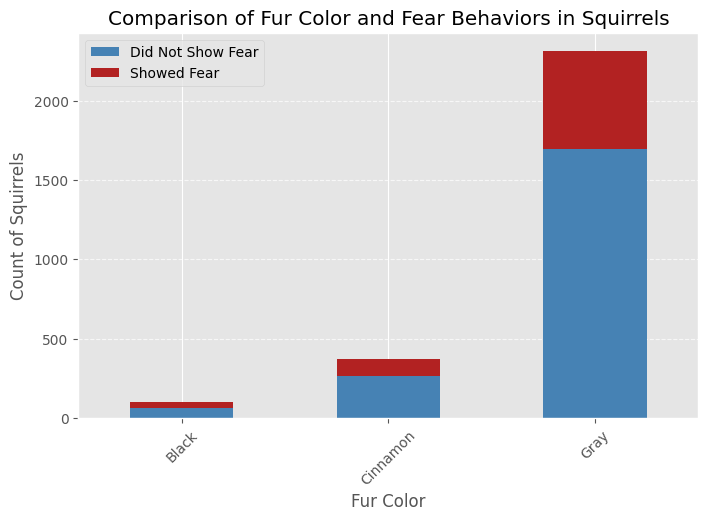

showed_fear_ap     False  True 
Primary Fur Color              
Black                 65     34
Cinnamon             267    107
Gray                1694    617

Chi-Square statistic: 3.2171419458335593
Degrees of freedom: 2
Expected frequencies:
[[  72.04525862   26.95474138]
 [ 272.17097701  101.82902299]
 [1681.78376437  629.21623563]]
P-value: 0.20017346308360082


,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Combination of Primary and Highlight Color,...,Kuks,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from,Lat/Long,showed_fear_ap
6,-73.954120,40.793181,36H-AM-1010-02,36H,AM,10102018,2,Adult,Gray,Gray+,...,False,False,False,False,False,False,False,False,POINT (-73.9541201789795 40.7931811701082),False
7,-73.958269,40.791737,33F-AM-1008-02,33F,AM,10082018,2,Adult,Gray,Gray+,...,False,False,False,False,False,False,True,False,POINT (-73.9582694312289 40.7917367820255),False
8,-73.967429,40.782972,21C-PM-1006-01,21C,PM,10062018,1,Adult,Gray,Gray+,...,False,False,False,True,True,False,False,False,POINT (-73.9674285955293 40.7829723919744),True
9,-73.972250,40.774288,11D-AM-1010-03,11D,AM,10102018,3,Adult,Gray,Gray+Cinnamon,...,False,False,False,False,False,False,True,False,POINT (-73.9722500196844 40.7742879599026),False
10,-73.969506,40.782351,20B-PM-1013-05,20B,PM,10132018,5,Adult,Gray,Gray+White,...,False,False,False,False,False,False,True,False,POINT (-73.9695063535333 40.7823507678183),False


In [15]:
#See if physical characteristics and fear have a relation

fear_columns_ap = ['Quaas', 'Moans', 'Tail flags', 'Runs from']

#Group by fur color and count how many did/didn't show fear
fur_fear_ap = clean_squirrels_ap.groupby("Primary Fur Color")["showed_fear_ap"].value_counts().unstack()

print(clean_squirrels_ap["showed_fear_ap"].value_counts())

#Plot
fur_fear_ap.plot(kind="bar", stacked=True, figsize=(8, 5), color=["steelblue", "firebrick"])
print(fur_fear_ap)

plt.title("Comparison of Fur Color and Fear Behaviors in Squirrels")
plt.xlabel("Fur Color")
plt.ylabel("Count of Squirrels")
plt.legend(["Did Not Show Fear", "Showed Fear"])
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


fur_fear_ap = clean_squirrels_ap.groupby("Primary Fur Color")["showed_fear_ap"].value_counts().unstack(fill_value=0)

#contingency table
print(fur_fear_ap)

#Chi-Square test
chi2, p, dof, expected = chi2_contingency(fur_fear_ap)

print(f"\nChi-Square statistic: {chi2}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies:\n{expected}")
print(f"P-value: {p}")

clean_squirrels_ap.head()

showed_fear_ap
False    2026
True      758
Name: count, dtype: int64


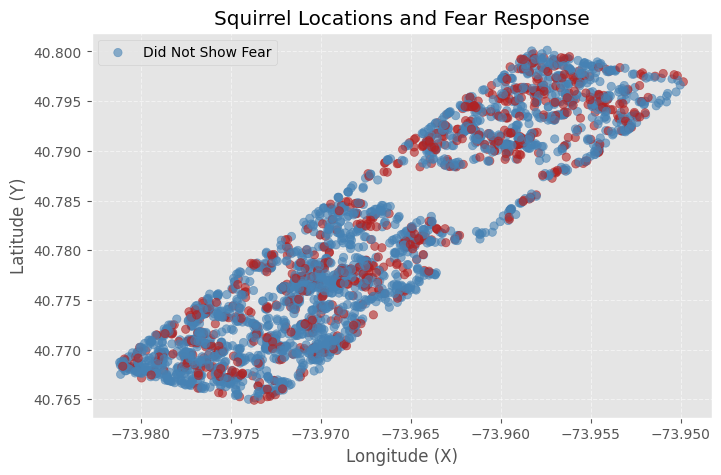


Chi-Square statistic: 2784.000000000001
Degrees of freedom: 2783
Expected frequencies:
[[0.72772989 0.27227011]
 [0.72772989 0.27227011]
 [0.72772989 0.27227011]
 ...
 [0.72772989 0.27227011]
 [0.72772989 0.27227011]
 [0.72772989 0.27227011]]
P-value: 0.49108917947949066


In [16]:
#See if fear and location have a relationship

loc_fear_ap = clean_squirrels_ap.groupby("Lat/Long")["showed_fear_ap"].value_counts().unstack(fill_value=0)
print(clean_squirrels_ap["showed_fear_ap"].value_counts())

colors = clean_squirrels_ap["showed_fear_ap"].map({True: "firebrick", False: "steelblue"})

#Plot
plt.figure(figsize=(8, 5))
plt.scatter(clean_squirrels_ap["X"], clean_squirrels_ap["Y"], c=colors, alpha=0.6)

plt.title("Squirrel Locations and Fear Response")
plt.xlabel("Longitude (X)")
plt.ylabel("Latitude (Y)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(["Did Not Show Fear", "Showed Fear"])

plt.show()

#Chi-Square test
chi2, p, dof, expected = chi2_contingency(loc_fear_ap)

print(f"\nChi-Square statistic: {chi2}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies:\n{expected}")
print(f"P-value: {p}")

showed_fear_ap
False    2026
True      758
Name: count, dtype: int64


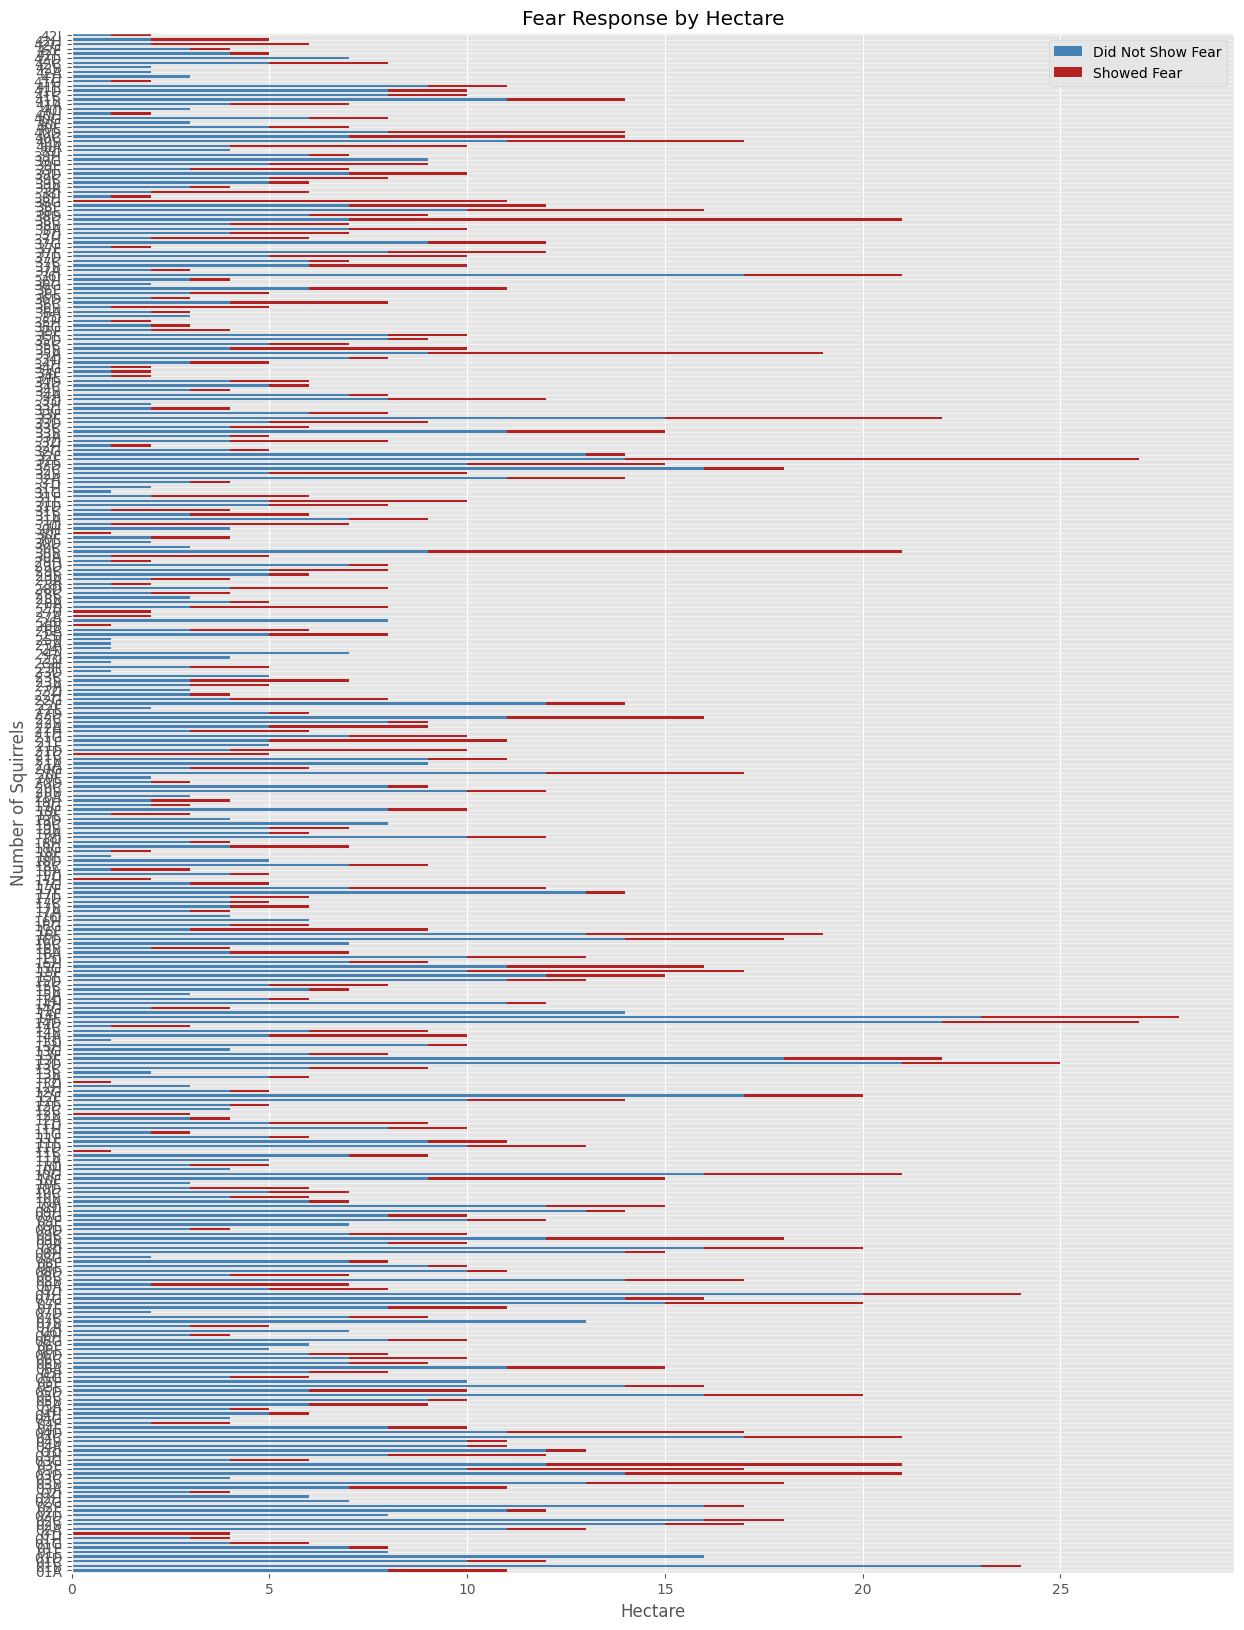


Chi-Square statistic: 512.2570827778108
Degrees of freedom: 333
Expected frequencies:
[[ 8.00502874  2.99497126]
 [17.46551724  6.53448276]
 [ 8.73275862  3.26724138]
 [11.64367816  4.35632184]
 [ 5.82183908  2.17816092]
 [ 5.82183908  2.17816092]
 [ 4.36637931  1.63362069]
 [ 2.91091954  1.08908046]
 [ 2.91091954  1.08908046]
 [ 9.46048851  3.53951149]
 [12.37140805  4.62859195]
 [13.09913793  4.90086207]
 [ 5.82183908  2.17816092]
 [ 8.73275862  3.26724138]
 [12.37140805  4.62859195]
 [ 5.0941092   1.9058908 ]
 [ 4.36637931  1.63362069]
 [ 2.91091954  1.08908046]
 [ 8.00502874  2.99497126]
 [13.09913793  4.90086207]
 [ 2.91091954  1.08908046]
 [15.28232759  5.71767241]
 [12.37140805  4.62859195]
 [15.28232759  5.71767241]
 [ 4.36637931  1.63362069]
 [ 8.73275862  3.26724138]
 [ 9.46048851  3.53951149]
 [ 8.00502874  2.99497126]
 [ 8.00502874  2.99497126]
 [15.28232759  5.71767241]
 [12.37140805  4.62859195]
 [ 7.27729885  2.72270115]
 [ 2.91091954  1.08908046]
 [ 2.91091954  1.08908

In [17]:
#Hectare and fear response relationship

hect_fear_ap = clean_squirrels_ap.groupby("Hectare")["showed_fear_ap"].value_counts().unstack(fill_value=0)
print(clean_squirrels_ap["showed_fear_ap"].value_counts())

#Plot
hect_fear_ap.plot(kind="barh", stacked=True, figsize=(15, 20), color=["steelblue", "firebrick"])

plt.title("Fear Response by Hectare")
plt.xlabel("Hectare", rotation=0)
plt.ylabel("Number of Squirrels")
plt.legend(["Did Not Show Fear", "Showed Fear"])
plt.xticks(rotation=0) 
plt.grid(axis="y", alpha=0.5)

plt.show()

#Chi-Square test
chi2, p, dof, expected = chi2_contingency(hect_fear_ap)

print(f"\nChi-Square statistic: {chi2}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies:\n{expected}")
print(f"P-value: {p}")

showed_fear_ap
False    2026
True      758
Name: count, dtype: int64


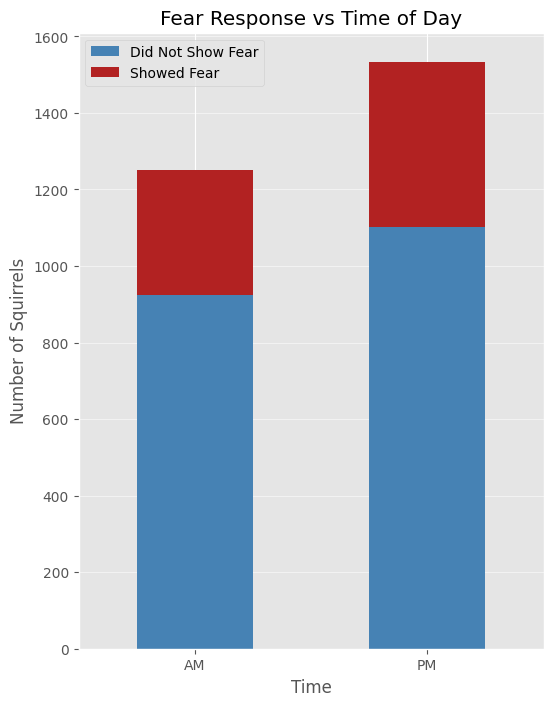


Chi-Square statistic: 1.0744388038581123
Degrees of freedom: 1
Expected frequencies:
[[ 910.39008621  340.60991379]
 [1115.60991379  417.39008621]]
P-value: 0.2999449732164572


In [18]:
#day/night and fear response relationship

time_fear_ap = clean_squirrels_ap.groupby("Shift")["showed_fear_ap"].value_counts().unstack(fill_value=0)
print(clean_squirrels_ap["showed_fear_ap"].value_counts())

#Plot
time_fear_ap.plot(kind="bar", stacked=True, figsize=(6, 8), color=["steelblue", "firebrick"])

plt.title("Fear Response vs Time of Day")
plt.xlabel("Time", rotation=0)
plt.ylabel("Number of Squirrels")
plt.legend(["Did Not Show Fear", "Showed Fear"])
plt.xticks(rotation=0) 
plt.grid(axis="y", alpha=0.5)

plt.show()

#Chi-Square test
chi2, p, dof, expected = chi2_contingency(time_fear_ap)

print(f"\nChi-Square statistic: {chi2}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies:\n{expected}")
print(f"P-value: {p}")

showed_fear_ap
False    2026
True      758
Name: count, dtype: int64


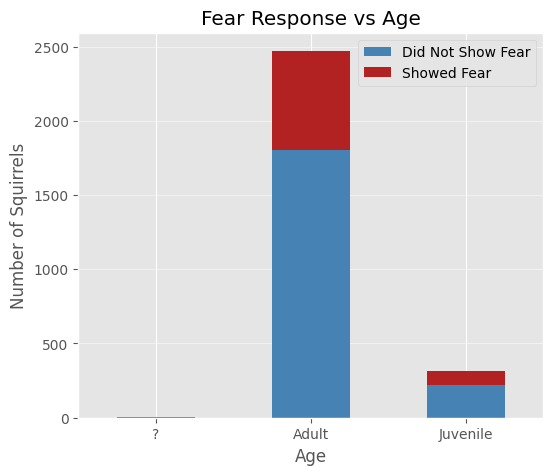


Chi-Square statistic: 1.6391814532808715
Degrees of freedom: 2
Expected frequencies:
[[1.45545977e+00 5.44540230e-01]
 [1.79749282e+03 6.72507184e+02]
 [2.27051724e+02 8.49482759e+01]]
P-value: 0.4406119483411123


In [19]:
#age and fear response relationship

age_fear_ap = clean_squirrels_ap.groupby("Age")["showed_fear_ap"].value_counts().unstack(fill_value=0)
print(clean_squirrels_ap["showed_fear_ap"].value_counts())

#Plot
age_fear_ap.plot(kind="bar", stacked=True, figsize=(6, 5), color=["steelblue", "firebrick"])

plt.title("Fear Response vs Age")
plt.xlabel("Age", rotation=0)
plt.ylabel("Number of Squirrels")
plt.legend(["Did Not Show Fear", "Showed Fear"])
plt.xticks(rotation=0) 
plt.grid(axis="y", alpha=0.5)

plt.show()

#Chi-Square test
chi2, p, dof, expected = chi2_contingency(age_fear_ap)

print(f"\nChi-Square statistic: {chi2}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies:\n{expected}")
print(f"P-value: {p}")

In [20]:
#mapping the squirrels"

#Determine the center of your map
center_lat_mc = nyc_squirrels['X'].mean() 
center_lon_mc = nyc_squirrels['Y'].mean()  

# Create the map object",
my_map_mc = folium.Map(location=[center_lat_mc, center_lon_mc], zoom_start=10)

for index, row in nyc_squirrels.iterrows():
    folium.Marker([row['X'], row['Y']], popup=row['Unique Squirrel ID']).add_to(my_map_mc)  
my_map_mc.save("my_map.html")

In [21]:
#Internal hectares and perimeter hectares

#Convert the WKT geometry column to shapely geometries
hectare['geometry'] = hectare['the_geom'].apply(wkt.loads)

#Create a GeoDataFrame from the regular DataFrame
hectare_gdf = gpd.GeoDataFrame(hectare, geometry='geometry')

#Set a coordinate reference system (CRS) — assuming WGS84 here, adjust if you know the CRS
hectare_gdf.set_crs("EPSG:4326", inplace=True)


,the_geom,id,xmin,xmax,ymin,ymax,geometry
0,MULTIPOLYGON (((-73.95816284567162 40.80102139...,82,989030.73113,989358.81512,231243.27134,231571.35533,"MULTIPOLYGON (((-73.95816 40.80102, -73.95713 ..."
1,MULTIPOLYGON (((-73.95712568765475 40.80058581...,83,989358.81512,989686.89911,231243.27134,231571.35533,"MULTIPOLYGON (((-73.95713 40.80059, -73.95609 ..."
2,MULTIPOLYGON (((-73.95608854321127 40.80015023...,84,989686.89911,990014.98310,231243.27134,231571.35533,"MULTIPOLYGON (((-73.95609 40.80015, -73.95505 ..."
3,MULTIPOLYGON (((-73.9550514123412 40.799714636...,85,990014.98310,990343.06709,231243.27134,231571.35533,"MULTIPOLYGON (((-73.95505 40.79971, -73.95401 ..."
4,MULTIPOLYGON (((-73.9540142950446 40.799279030...,86,990343.06709,990671.15108,231243.27134,231571.35533,"MULTIPOLYGON (((-73.95401 40.79928, -73.95298 ..."
...,...,...,...,...,...,...,...
373,MULTIPOLYGON (((-73.97750517097374 40.76696330...,865,990343.06709,990671.15108,217791.82775,218119.91174,"MULTIPOLYGON (((-73.97751 40.76696, -73.97647 ..."
374,MULTIPOLYGON (((-73.97646841686014 40.76652789...,866,990671.15108,990999.23507,217791.82775,218119.91174,"MULTIPOLYGON (((-73.97647 40.76653, -73.97543 ..."
375,MULTIPOLYGON (((-73.97543167630229 40.76609247...,867,990999.23507,991327.31906,217791.82775,218119.91174,"MULTIPOLYGON (((-73.97543 40.76609, -73.97439 ..."
376,MULTIPOLYGON (((-73.97439494930025 40.76565705...,868,991327.31906,991655.40305,217791.82775,218119.91174,"MULTIPOLYGON (((-73.97439 40.76566, -73.97336 ..."


      id  is_interior  is_perimeter
0     82        False          True
1     83        False          True
2     84        False          True
3     85        False          True
4     86        False          True
..   ...          ...           ...
373  865        False          True
374  866        False          True
375  867        False          True
376  868        False          True
377  869        False          True

[378 rows x 3 columns]


/var/folders/4k/j4g2lqw57x957sw_c6pdfy4w0000gn/T/ipykernel_14708/1113200846.py:28: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/4k/j4g2lqw57x957sw_c6pdfy4w0000gn/T/ipykernel_14708/1113200846.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


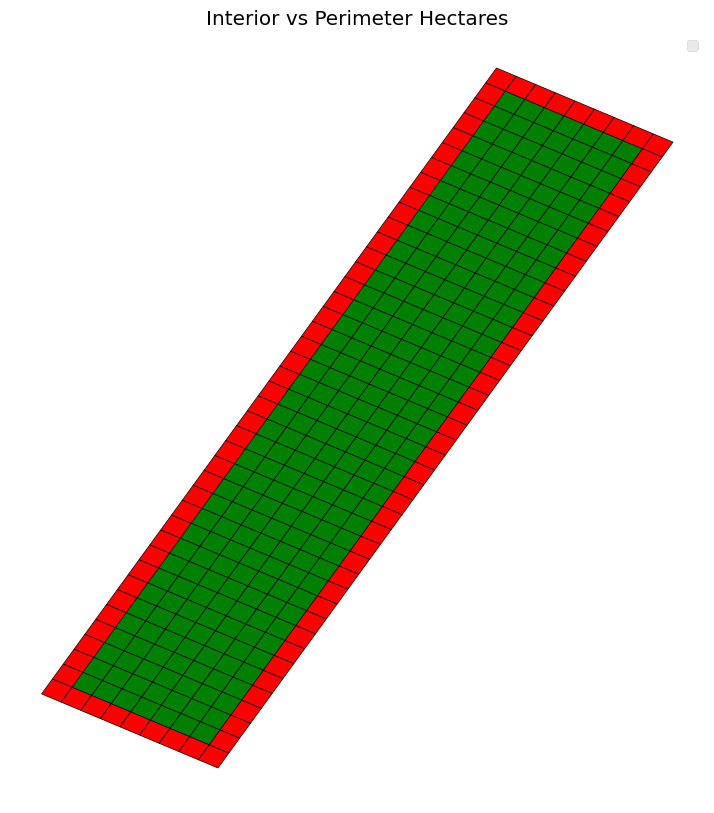

In [23]:
#Separating perimeter hectares and intenral hectares

# Load and convert geometries
hectare['geometry'] = hectare['the_geom'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(hectare, geometry='geometry')

#Find outer limits of the grid
min_x = gdf['xmin'].min()
max_x = gdf['xmax'].max()
min_y = gdf['ymin'].min()
max_y = gdf['ymax'].max()

#Mark perimeter: anything that touches the bounding box of the grid
gdf['is_perimeter'] = (
    (gdf['xmin'] == min_x) | (gdf['xmax'] == max_x) |
    (gdf['ymin'] == min_y) | (gdf['ymax'] == max_y)
)

#Mark interior as not perimeter
gdf['is_interior'] = ~gdf['is_perimeter']

print(gdf[['id', 'is_interior', 'is_perimeter']])

#Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf[gdf['is_interior']].plot(ax=ax, color='green', edgecolor='black', label='Interior')
gdf[gdf['is_perimeter']].plot(ax=ax, color='red', edgecolor='black', label='Perimeter')
plt.legend()
plt.title("Interior vs Perimeter Hectares")
plt.axis('off') 
plt.show()

In [ ]:
#Dispays of fear
fear_columns_ap = ['Quaas', 'Moans', 'Tail flags', 'Runs from']
fear_ap = nyc_squirrels[fear_columns_ap].apply(pd.Series.value_counts)
print(fear_ap)

#add a new column where it is marked true if it showed at least one fear trait
nyc_squirrels["showed_fear_ap"] = nyc_squirrels[fear_columns_ap].applymap(
    lambda x: str(x).strip().lower() in ["yes", "true", "1"]
).any(axis=1)